# Mapping the GLS approach of https://github.com/kundajelab/coessentiality to our TnSeq dataset: 

## Import modules: 

In [32]:
import pandas as pd
import os
import numpy as np
from scipy.special import stdtr
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralBiclustering
import re

import numpy as np, pandas as pd, subprocess
from statsmodels.stats.multitest import fdrcorrection

from scipy.sparse import csr_matrix, save_npz
import sys
sys.path.append('/home/ajinich/Documents/repos/coessentiality/')
import diffmap as dm
import anndata as adata
import scanpy as sc

import hvplot.pandas

In [ ]:
import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import holoviews as hv 
import bokeh.io
import bokeh.plotting
import colorcet as cc

## Define functions: 

In [37]:
def linear_regression(warped_screens, warped_intercept):
    list_ind_err = []
    GLS_coef = np.empty((len(warped_screens), len(warped_screens)))
    GLS_se = np.empty((len(warped_screens), len(warped_screens)))
    ys = warped_screens.T
    for gene_index in range(len(warped_screens)):
        X = np.stack((warped_intercept, warped_screens[gene_index]), axis=1)
        coef, residues = np.linalg.lstsq(X, ys, rcond=None)[:2] # you need to understand this. 
        df = warped_screens.shape[1] - 2
        GLS_coef[gene_index] = coef[1]
        try:
            GLS_se[gene_index] = \
                np.sqrt(np.linalg.pinv(X.T @ X)[1, 1] * residues / df) # you need to understand this. 
        except:
            print(gene_index)
            list_ind_err.append(gene_index)
            
    return GLS_coef, GLS_se, list_ind_err

In [ ]:
def choose_k(data, max_clus):
    "Helper function to choose the number of clusters for KMeans."
    
    k_tests = np.arange(2, max_clus)
    wcss = []
    silhouettes_ = []
    for k in tqdm.tqdm(k_tests): 
        clustering = KMeans(k, random_state= 42).fit(data)
        wcss.append(clustering.inertia_)
        silhouettes_.append(silhouette_score(data, clustering.predict(data)))
    
    
    return wcss, silhouettes_

## Loading data: 

In [62]:
path_data_out = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq/'
path_data = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq'

In [34]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'

if version == 'old':
    fn = 'result_logfc_matrix_2020_08_27.csv' ## data set without Claire's screens
elif version == 'clare_all':
    fn = 'result_logfc_matrix_2021_08_27.csv' ## data set with all of Claire's pairwise combinations
elif version == 'clare_basis':
    fn = 'result_logfc_matrix_2021_08_27_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens

path = '../data/standardized_data/'
df_lfc = pd.read_csv(os.path.join(path, fn), index_col = 0)
print('size before dropping NA:', df_lfc.shape)

# Remove cell lines with any missing genes / data
df_lfc = df_lfc.dropna(axis=0)
print('size after dropping NA:', df_lfc.shape)

size before dropping NA: (4055, 125)
size after dropping NA: (3971, 125)


## [STEP 1]: GLS warping of TnSeq screen data and intercept based on covariance matrix


In [35]:
mat_data = df_lfc.values
cov_mat = np.cov(mat_data.T)
inv_mat = np.linalg.inv(cov_mat)
cholsigmainv = np.linalg.cholesky(inv_mat)
warped_screens = df_lfc.values @ cholsigmainv
warped_intercept = cholsigmainv.sum(axis=0)

In [38]:
GLS_coef, GLS_se, list_ind_err= linear_regression(warped_screens, warped_intercept)

661
675
1327
1908
1914
2429
2522
2625
2686
2696
3045
3654


In [39]:
list_genes_err = df_lfc.index[list_ind_err].tolist()
len(warped_screens) - len(list_ind_err)

3959

#### Dropping problematic genes / indices: 
Why are they problematic?

In [44]:
list_ind_good = [i for i in np.arange(len(warped_screens)) if not i in list_ind_err]
# Find a better way to drop rows / columns: 
GLS_coef_filt = GLS_coef[:,list_ind_good][list_ind_good]
GLS_se_filt = GLS_se[:,list_ind_good][list_ind_good]
GLS_coef.shape, GLS_coef_filt.shape

((3971, 3971), (3959, 3959))

In [45]:
# Compute matrix of p-values:
df = warped_screens.shape[1] - 2
GLS_p = 2 * stdtr(df, -np.abs(GLS_coef_filt / GLS_se_filt))
np.fill_diagonal(GLS_p, 1)

In [54]:
# Save everything
np.save(os.path.join(path_data_out, 'GLS_p_AJ.npy'), GLS_p)
np.save(os.path.join(path_data_out, 'GLS_sign_AJ.npy'), np.sign(GLS_coef_filt))
df_lfc.index[list_ind_good].to_series().to_csv( os.path.join(path_data_out, 'genes_AJ.txt'), index=False, header=False)

#### [PENDING]: Perform p-value statistics as in the Nat. Genetics paper. 

# [STEP 2]: Generate gene modules using ClusteOne: 

In [58]:
genes = pd.read_csv( os.path.join(path_data_out,'genes_AJ.txt') , header=None, squeeze=True)
GLS_p = pd.DataFrame( np.load(os.path.join(path_data_out, 'GLS_p_AJ.npy')), columns=genes, index=genes)

In [63]:
# Compute and save weights for ClusterONE
stacked_p = GLS_p.stack()
stacked_p = stacked_p[stacked_p.index.get_level_values(0) < stacked_p.index.get_level_values(1)]
# Bonferroni-corrected p-values: 
fdr = pd.Series(fdrcorrection(stacked_p)[1], index=stacked_p.index)

In [64]:

weights = 1 - fdr
weight_file = os.path.join(path_data_out, 'ClusterONE_weights_AJ.txt')
weights.to_csv(weight_file, sep=' ', header=None)

####  Run ClusterONE at each value of d, and save results

[WARNING]: These steps take quite a bit of time

[WARNING]: Move output files to a different location

In [67]:
list_d = [0.2, 0.5, 0.9]
for d in list_d:
    subprocess.check_call(f' java -jar /home/ajinich/cluster_one-1.0.jar {weight_file} 'f'-d {d} -F csv > modules_d_{d}.csv', shell=True)

Loaded graph with 3959 nodes and 7834861 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 164 complexes
Loaded graph with 3959 nodes and 7834861 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 850 complexes
Loaded graph with 3959 nodes and 7834861 edges
[====================] 100% Growing clusters from seeds...
[====================] 100% Finding highly overlapping clusters...
[====================] 100% Merging highly overlapping clusters...
Detected 328 complexes


# [STEP 3]: Generate layout via ClusterOne modules: 

In [69]:
# Read in GLS p-values.
pairwise_distances = np.load(os.path.join(path_data_out, 'GLS_p_AJ.npy'))
fn_gene_names = os.path.join(path_data_out, 'genes_AJ.txt')
gene_names = np.ravel( pd.read_csv(fn_gene_names, header=None))
len(pairwise_distances), len(gene_names)

(3959, 3959)

#### [WARNING]: did the fact that you dropped some columns change the gene-to-index mapping?

In [70]:
fn = 'modules_d_0.9.csv'
df_cone = pd.read_csv(os.path.join(path_data, fn))
nclusts = df_cone.shape[0]
df_cone.head(2)

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members
0,1,5,0.9119,9.119,572.7,0.01541,0.996692,Rv0001 Rv1308 Rv1479 Rv2720 Rv3811
1,2,16,0.9141,109.700,1832.0,0.05557,0.999999,Rv0002 Rv0526 Rv0684 Rv1098c Rv1208 Rv1402 Rv1...


In [71]:
df_cone.shape

(328, 8)

##### [WARNING] the p-values are not significant. Is that a problem? 

#### Build and save sparse membership matrix: 

In [6]:
cluster_ndces = {}
for gname in gene_names:
    cluster_ndces[gname] = df_cone[df_cone.Members.str.contains(gname)].Cluster.values - 1
# cluster membership matrix: 
clust_mmships = np.zeros((len(gene_names), nclusts)) 
for i in range(len(gene_names)):
    clust_mmships[i, cluster_ndces[gene_names[i]]] = 1
clust_mmships = csr_matrix(clust_mmships)
save_npz('clusterone_memberships_AJ.npz', clust_mmships)

#### Build and save pairwise Jaccard similarities between genes, according to the clusterings given.


In [8]:
gg_jaccsims = dm.pairwise_jaccard_graph(clust_mmships)
gm_inc = dm.build_knn(gg_jaccsims, k=10, symmetrize_type='inclusive')

#### Use GLS -log(p) values between each pair of genes (the (genes x genes) matrix GLS_p) as the adjacency matrix of the GLS graph.

In [9]:
a = -np.log(pairwise_distances)
a[np.isinf(a)] = 0
GLS_pvals_100 = dm.build_knn(a, k=100, symmetrize_type='inclusive')
GLS_pvals_10 = dm.build_knn(GLS_pvals_100, k=10, symmetrize_type='inclusive')
save_npz('GLS_pvals_10NN_AJ.npz', GLS_pvals_10)

#### Construct the combined graph

In [10]:
frac_CO_graph = 0.99
frac_GLS_graph = 1-frac_CO_graph
CO_graph = gm_inc
GLS_graph = GLS_pvals_10

In [11]:
adj_mat = csr_matrix( (frac_CO_graph * CO_graph) + (frac_GLS_graph * GLS_graph) )
n_cmps = 100
reduced_dim = 50
sffix = "_GLS_AJ"
vizdf_filename = "vizdf{}.csv".format(sffix)

In [12]:
emap_heat = dm.diffmap_proj(adj_mat, n_comps=n_cmps, n_dims=40, min_energy_frac=0.9, embed_type='diffmap', return_eigvals=False)


41 dimensions contain about 0.8999999999999999 fraction of the variance in the first 100 dimensions (Diffusion time = 33.52407829929874)


In [13]:
ann_heat = adata.AnnData(X=emap_heat[:, :40])

In [15]:
sc.pp.neighbors(ann_heat)
sc.tl.umap(ann_heat)

In [19]:
heat_umap = np.array(ann_heat.obsm['X_umap'])

In [20]:
vizdf = pd.DataFrame(data=heat_umap, columns=['hUMAP_x', 'hUMAP_y'])
vizdf['gene_names'] = gene_names
vizdf.to_csv(vizdf_filename, sep="\t", index=False)


# Interactive plotting: 

In [18]:
sffix = "_GLS_AJ"
vizdf_filename = "vizdf{}.csv".format(sffix)
vizdf = pd.read_csv(vizdf_filename, sep = '\t')

In [19]:
vizdf.hvplot.scatter(x="hUMAP_x", y="hUMAP_y", padding=0.05, width = 1000, height = 800, size = 55, alpha = 0.7, 
                     hover_cols=['gene_names'], line_color='k')


:Scatter   [hUMAP_x]   (hUMAP_y,gene_names)

In [21]:
data = vizdf[['hUMAP_x', 'hUMAP_y']].values

In [23]:
%%time
wcss, sil = choose_k(data, max_clus = 60)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:31<00:00,  1.83it/s]

CPU times: user 7min 32s, sys: 13.9 s, total: 7min 46s
Wall time: 31.8 s


In [24]:
wcss_plot = hv.Curve((wcss), label="Within cluster sum of squares").opts(
    xlabel="number of clusters",
    ylabel="WCSS",
    padding=0.1,
    tools=["hover"],
    color="orange",
)
silhouette_plot = hv.Curve((sil), label="silhouette score").opts(
    xlabel="number of clusters", ylabel="silhouette score", padding=0.1, tools=["hover"]
)

wcss_plot + silhouette_plot.opts(shared_axes = False)

:Layout
   .Curve.Within_cluster_sum_of_squares :Curve   [x]   (y)
   .Curve.Silhouette_score              :Curve   [x]   (y)

In [25]:
seed = 43
np.random.seed(seed)

num_clus = 60
clustering = KMeans(n_clusters = num_clus, random_state= seed).fit(data)
cluster_labels = clustering.labels_

In [26]:
vizdf['cluster_labels'] = cluster_labels

In [27]:
vizdf.hvplot.scatter(x="hUMAP_x", y="hUMAP_y", padding=0.05, width = 1500, height = 800, size = 55, alpha = 0.7, 
                     hover_cols=['gene_names'], line_color='k', c = 'cluster_labels', clabel = 'clusters', cmap = cc.glasbey[:num_clus])


:Scatter   [hUMAP_x]   (hUMAP_y,cluster_labels,gene_names)

In [73]:
vizdf[vizdf.cluster_labels==3].shape

(42, 4)

In [114]:
list_clus = [3, 7, 22, 17, 18, 13]

In [118]:
import seaborn as sns

In [119]:
colors = sns.color_palette('tab10')

In [127]:
colors = colors[:5] + colors[6:]

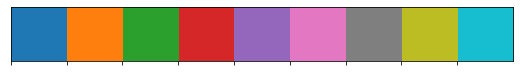

In [129]:
sns.palplot(colors)

Where do the SDRs fall?

In [151]:
fn_sdr = '../data/tests/SDR_IB_vs_soluble_mapping.xlsx'
df_sdr = pd.read_excel(fn_sdr)
df_sdr.head()

,Well,Rv_ID,MW_kDa,MW_wTag_kda,IB_vs_soluble_BB_100uM_16C,IB_vs_soluble_BB_1mM_37C,insert_len,insert_seq,construct_len,construct_seq
0,A1,Rv3791,27.0,41.0,soluble,NaN,765.0,ATGGTCCTGGATGCAGTAGGAAATCCACAAACCGTTCTGCTGCTGG...,6336.0,TGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTGGCTG...
1,A2,Rv0927c,27.0,41.0,IB,NaN,792.0,ATGATTCTGGATATGTTCCGTTTGGACGATAAAGTTGCTGTAATTA...,6363.0,TGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTGGCTG...
2,A3,Rv1928c,27.0,41.0,IB,NaN,768.0,ATGTCCGTACTCGACCTTTTTGATCTCCACGGTAAACGCGCTCTGA...,6339.0,TGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTGGCTG...
3,A4,Rv2509,28.0,42.0,IB,NaN,807.0,ATGCCAATTCCGGCCCCATCACCGGATGCACGTGCCGTAGTTACTG...,6378.0,TGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTGGCTG...
4,A5,Rv1543,37.0,51.0,IB,NaN,1026.0,ATGAATTTGGGTGACCTGACCAATTTTGTTGAAAAGCCGCTGGCAG...,6597.0,TGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTGGCTG...


In [154]:
df_sdr_clus = vizdf[vizdf.Rv_ID.isin(df_sdr.Rv_ID)]
df_sdr_clus.shape

(49, 4)

In [1]:
clus = 17
plt.figure(figsize=(18,12))
plt.scatter(vizdf.hUMAP_x, vizdf.hUMAP_y, s=100, color = colors[-3], edgecolors='k', alpha=0.25)
counter = 0
df_sdr_clus = vizdf[vizdf.Rv_ID.isin(df_sdr.Rv_ID)]
plt.scatter(df_sdr_clus.hUMAP_x, df_sdr_clus.hUMAP_y, s=200, color = colors[counter], edgecolors='k', linewidths=3, alpha=0.75)
counter += 1

NameError: name 'plt' is not defined

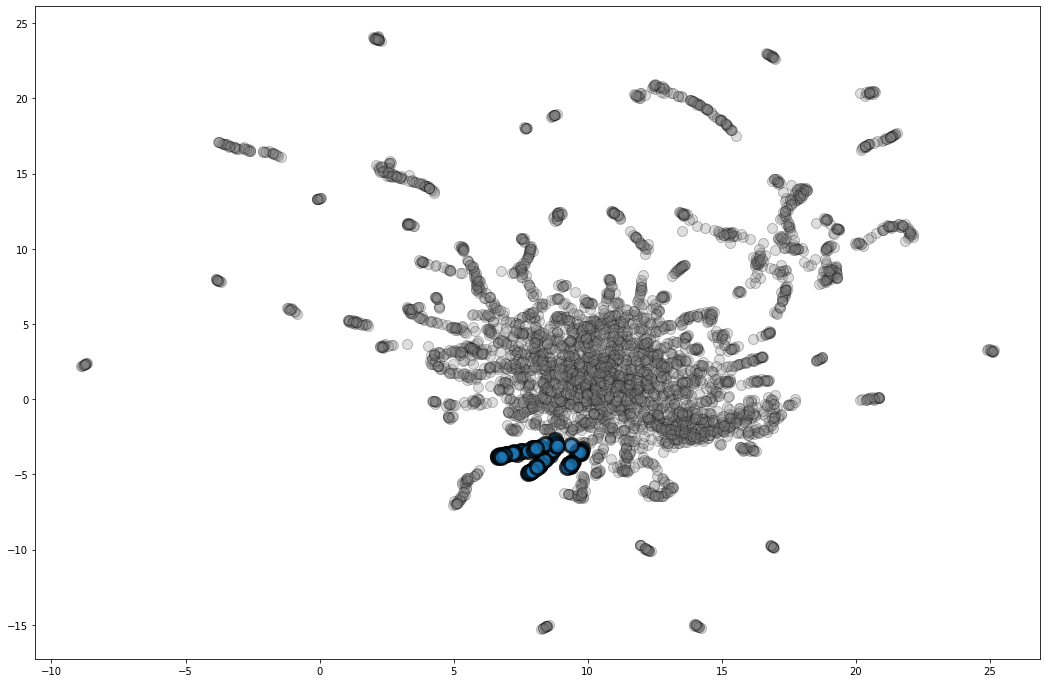

In [149]:
clus = 22
plt.figure(figsize=(18,12))
plt.scatter(vizdf.hUMAP_x, vizdf.hUMAP_y, s=100, color = colors[-3], edgecolors='k', alpha=0.25)
df_clus = vizdf[vizdf.cluster_labels==clus]
plt.scatter(df_clus.hUMAP_x, df_clus.hUMAP_y, s=200, color = colors[counter], edgecolors='k', linewidths=3, alpha=0.75)
counter += 1

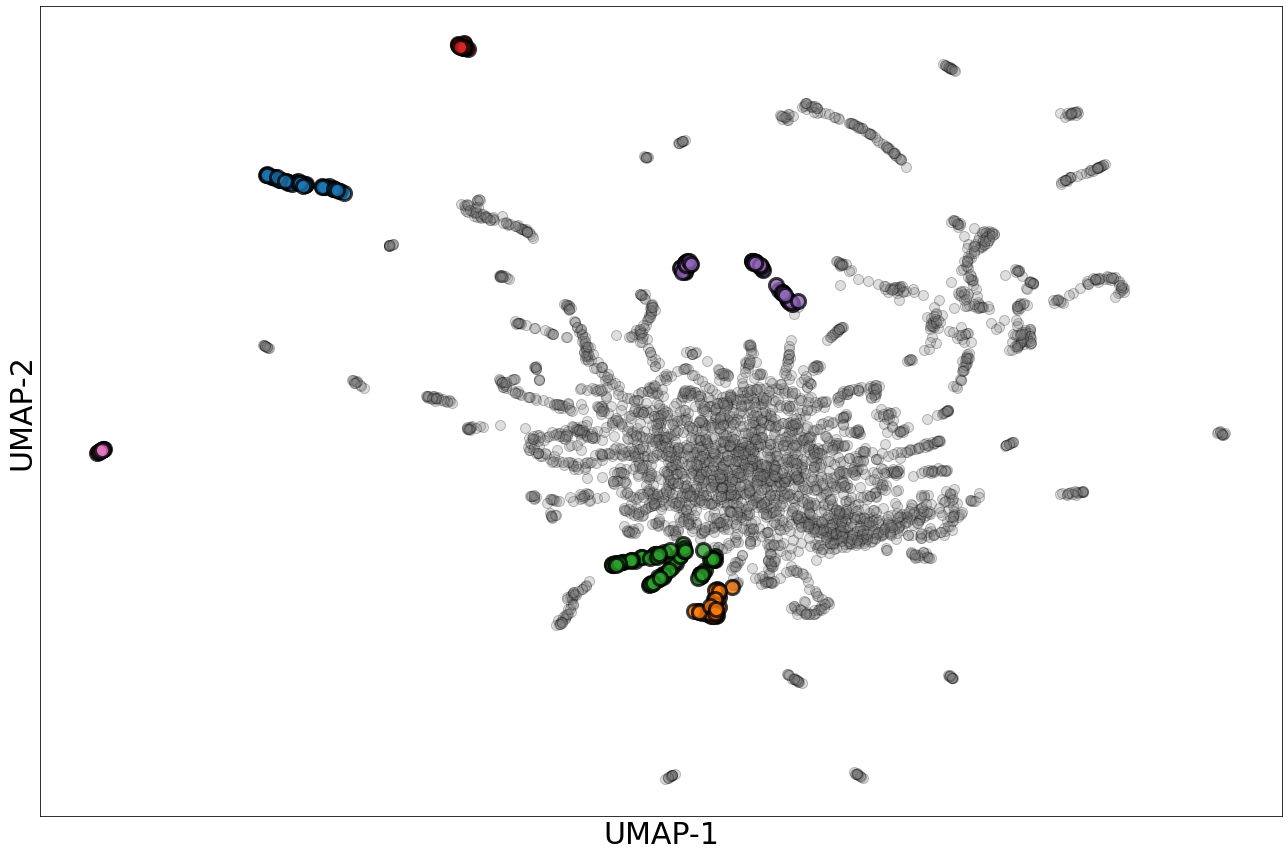

In [145]:

plt.figure(figsize=(18,12))
plt.scatter(vizdf.hUMAP_x, vizdf.hUMAP_y, s=100, color = colors[-3], edgecolors='k', alpha=0.25)
counter = 0
for clus in list_clus:
    df_clus = vizdf[vizdf.cluster_labels==clus]
    plt.scatter(df_clus.hUMAP_x, df_clus.hUMAP_y, s=200, color = colors[counter], edgecolors='k', linewidths=3, alpha=0.75)
    counter += 1
plt.xlabel('UMAP-1', fontsize = 30)
plt.ylabel('UMAP-2', fontsize = 30)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
fig_name = '../figures/genome_visualizations/GLS_UMAP.png'
plt.tight_layout()
plt.savefig(fig_name, dpi=300)

In [71]:
df_up_func[(df_up_func.cluster_labels == clus)].sort_values(by='annot_int', ascending = False)

,Rv_ID,annot_int,Gene names,Function [CC],hUMAP_x,hUMAP_y,cluster_labels
1265,Rv0282,4,eccA3 Rv0282 MTV035.10,FUNCTION: Part of the ESX-3 specialized secret...,-1.768800,16.366170,3
319,Rv3425,3,PPE57 Rv3425 MTCY78.04c,FUNCTION: Plays a key role in regulating innat...,-1.724134,16.337269,3
387,Rv0683,3,rpsG rps7 Rv0683 MTV040.11,FUNCTION: One of the primary rRNA binding prot...,-1.755439,16.344135,3
743,Rv2157c,3,murF Rv2157c MTCY270.11,FUNCTION: Involved in cell wall formation. Cat...,-1.544146,16.195034,3
891,Rv0706,3,rplV Rv0706 MTCY210.25,FUNCTION: This protein binds specifically to 2...,-1.722152,16.323692,3
1909,Rv3117,3,cysA1 cysA Rv3117 MTCY164.27; cysA2 Rv0815c MT...,FUNCTION: May be a sulfotransferase involved i...,-2.828046,16.650856,3
566,Rv0796,2,Rv0796 MTV042.06; Rv1369c MTCY02B12.03c; Rv175...,FUNCTION: Involved in the transposition of the...,-3.541087,16.943958,3
1911,Rv1199c,2,Rv1199c MTCI364.11c; Rv2512c MTCY07A7.18c,FUNCTION: Required for the transposition of th...,-2.603093,16.521818,3
2552,Rv0515,1,Rv0515,NaN,-1.902512,16.470652,3
2629,Rv0094c,1,Rv0094c Rv3467,NaN,-3.347611,16.823418,3


## Add protein annotations to cluster dataframe:

In [42]:
file_UP = '../data/annotations/uniprot_annotation_scores.csv'
df_UP = pd.read_csv(file_UP)
df_UP.head(2)

,Rv_ID,Annotation
0,Rv0001,4
1,Rv0002,4


In [44]:
vizdf.rename(columns={'gene_names':'Rv_ID'}, inplace=True)
vizdf_UP = vizdf.merge(df_UP, on='Rv_ID', how = 'left')

In [53]:
df_clus_to_annot = pd.read_csv('../data/tests/cluster_annotation_GSL.csv')
df_clus_to_annot.head()

,cluster_number,who,label
0,13,sakila,NaN
1,27-a,sakila,NaN
2,27-b,sakila,NaN
3,3-a,sakila,NaN
4,3-b,sakila,NaN


In [54]:
list_clus = list(set([int(c.split('-')[0]) for c in df_clus_to_annot.cluster_number]))

In [56]:
path_out = '../data/tests/'
for clus in list_clus:
    df_temp = vizdf_UP[(vizdf_UP.cluster_labels == clus)]
    df_temp.sort_values( by = 'Annotation', ascending = False )
    fn_out = os.path.join(path_out, 'cluster_'+str(clus)+'.xlsx')
    df_temp[['Rv_ID', 'cluster_labels', 'Annotation']].to_excel(fn_out, index = False)

In [90]:
df_temp

,hUMAP_x,hUMAP_y,Rv_ID,cluster_labels,Annotation
3847,0.01303,13.352503,Rv3810,55,4.0


### An alternative way to do this: 

In [106]:
fn_up_func = '../data/tests/uniprot-proteome_UP000001584.xlsx'
df_up_func = pd.read_excel(fn_up_func)

/home/ajinich/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [113]:
len(list_many_rvids)

20

In [112]:
re_str = 'Rv\d\d\d\dc?'
list_rvids = [(str_temp, re.findall(re_str, str_temp)) for str_temp in df_up_func['Gene names']]
list_many_rvids = [rvs for rvs in list_rvids if len(rvs[1])>1]

In [102]:
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_up_func['Gene names']]
df_up_func['Rv_ID'] = list_rvids
df_up_func.sort_values(by = 'Rv_ID', inplace=True)
df_up_func['annot_int'] = [int(annot.split()[0]) for annot in df_up_func.Annotation]
# df_up_func = df_up_func[['Rv_ID', 'annot_int', 'Gene names', 'Function [CC]']].copy()

In [105]:
df_up_func[df_up_func.Entry == 'P9WHF9']

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Annotation,Rhea ID,EC number,Catalytic activity,ChEBI,Sequence,Function [CC],Rv_ID,annot_int
1922,P9WHF9,THTR_MYCTU,reviewed,Putative thiosulfate sulfurtransferase (EC 2.8...,cysA1 cysA Rv3117 MTCY164.27; cysA2 Rv0815c MT...,Mycobacterium tuberculosis (strain ATCC 25618 ...,277.0,3 out of 5,RHEA:16881,2.8.1.1,CATALYTIC ACTIVITY: Reaction=hydrogen cyanide ...,H(+) [CHEBI:15378]; thiosulfate [CHEBI:33542];...,MARCDVLVSADWAESNLHAPKVVFVEVDEDTSAYDRDHIAGAIKLD...,FUNCTION: May be a sulfotransferase involved i...,Rv3117,3


In [76]:
df_up_func = df_up_func.merge(vizdf, how = 'inner', on = 'Rv_ID').copy()
df_up_func.head(2)

,Rv_ID,annot_int,Gene names,Function [CC],hUMAP_x,hUMAP_y,cluster_labels
0,Rv3112,2,moaD1 Rv3112 LH57_16990,FUNCTION: Involved in sulfur transfer in the c...,14.219461,-1.957264,0
1,Rv0137c,4,msrA Rv0137c MTCI5.11c,FUNCTION: Has an important function as a repai...,9.160718,-0.405125,52


In [88]:
list_clus3 = vizdf[vizdf.cluster_labels == 3].Rv_ID.tolist()
list_clus3[:10]

['Rv0094c',
 'Rv0282',
 'Rv0515',
 'Rv0683',
 'Rv0706',
 'Rv0796',
 'Rv0815c',
 'Rv1047',
 'Rv1199c',
 'Rv1369c']

In [94]:
df_up_func[df_up_func.Rv_ID.str.contains('Rv081')]

,Rv_ID,annot_int,Gene names,Function [CC]
821,Rv0814c,2,sseC2 Rv0814c,NaN
1735,Rv0819,5,mshD Rv0819,FUNCTION: Catalyzes the transfer of acetyl fro...
1977,Rv0813c,3,Rv0813c,FUNCTION: May play a role in the intracellular...
2438,Rv0812,1,Rv0812,NaN
2533,Rv0811c,1,Rv0811c,NaN
2574,Rv0810c,1,Rv0810c,NaN
2806,Rv0816c,1,thiX Rv0816c,NaN
3559,Rv0817c,1,Rv0817c,NaN
3686,Rv0818,2,Rv0818,NaN


In [90]:
df_up_func[df_up_func.Rv_ID.isin(list_clus3)].sort_values(by = 'Rv_ID')

,Rv_ID,annot_int,Gene names,Function [CC]
2663,Rv0094c,1,Rv0094c Rv3467,NaN
1269,Rv0282,4,eccA3 Rv0282 MTV035.10,FUNCTION: Part of the ESX-3 specialized secret...
2586,Rv0515,1,Rv0515,NaN
390,Rv0683,3,rpsG rps7 Rv0683 MTV040.11,FUNCTION: One of the primary rRNA binding prot...
891,Rv0706,3,rplV Rv0706 MTCY210.25,FUNCTION: This protein binds specifically to 2...
571,Rv0796,2,Rv0796 MTV042.06; Rv1369c MTCY02B12.03c; Rv175...,FUNCTION: Involved in the transposition of the...
3992,Rv1047,1,Rv1047 Rv3023c Rv3115,FUNCTION: Required for the transposition of th...
1924,Rv1199c,2,Rv1199c MTCI364.11c; Rv2512c MTCY07A7.18c,FUNCTION: Required for the transposition of th...
3689,Rv1432,1,Rv1432,NaN
747,Rv2157c,3,murF Rv2157c MTCY270.11,FUNCTION: Involved in cell wall formation. Cat...


In [59]:
path_out = '../data/tests/'
for clus in list_clus:
    df_temp = df_up_func[(df_up_func.cluster_labels == clus)].copy()
    df_temp.sort_values(by = 'annot_int', ascending = False, inplace = True)
    fn_out = os.path.join(path_out, 'cluster_'+str(clus)+'.xlsx')
    df_temp[['Rv_ID', 'annot_int', 'Gene names', 'Function [CC]', 'cluster_labels']].to_excel(fn_out, index = False)

# OTHER: 

OUTDATED: testing which columns were giving us errors: 

In [30]:
# cols_ref_mouse = [col for col in df_lfc.columns if 'C57BL' in col]
# cols_OLD = [col for col in df_lfc.columns if col not in cols_ref_mouse]

# [col for col in cols_ref_mouse if col.split('_')[0] == 'C57BL.6J']

# # mat_data = df_lfc.values
# # for col in cols_ref_mouse:
# list_test_lamd = []
# list_error = []
# n_iter = 10000
# for ii in range(n_iter):
#     n_cols_rand = 10
#     cols_rand = random.sample(cols_ref_mouse, n_cols_rand)
#     cols_temp = cols_OLD + cols_rand
#     mat_data = df_lfc[cols_temp].values
#     cov_mat = np.cov(mat_data.T)
#     try:
#         inv_mat = np.linalg.inv(cov_mat)
#     except:
#         list_error.append(cols_rand)
#     lamb_cov = np.linalg.eigvalsh(cov_mat)[0]
#     lamb_inv = np.linalg.eigvalsh(inv_mat)[0]
#     if np.abs(lamb_cov) < 1e-10:
#         list_test_lamd.append(cols_rand)